#### Търсене и извличане на информация. Приложение на дълбоко машинно обучение
#### Стоян Михов
#### Зимен семестър 2024/2025

### Упражнение 4a

За да работи програмата трябва корпуса от публицистични текстове за Югоизточна Европа,
да се намира разархивиран в директорията, в която е програмата (виж упражнение 2).

Преди да се стартира програмата е необходимо да се активира съответното обкръжение с командата:
```
conda activate tii
```

In [4]:
import nltk
from nltk.corpus import PlaintextCorpusReader
import sys
import math

### Следващите няколко функции са (почти) идентични с тези от Упражнение 3

In [2]:
class progressBar:
    def __init__(self ,barWidth = 50):
        self.barWidth = barWidth
        self.period = None
    def start(self, count):
        self.period = int(count / self.barWidth)
        sys.stdout.write("["+(" " * self.barWidth)+"]")
        sys.stdout.flush()
        sys.stdout.write("\b" * (self.barWidth+1))
    def tick(self, item):
        if item>0 and item % self.period == 0:
            sys.stdout.write("-")
            sys.stdout.flush()
    def stop(self):
        sys.stdout.write("]\n")

In [5]:
corpus_root = '../JOURNALISM.BG/C-MassMedia'
myCorpus = PlaintextCorpusReader(corpus_root, '.*\.txt')
fileNames = myCorpus.fileids()

classesSet = set( [ file[:file.find('/')] for file in fileNames ] )
classes = sorted(list(classesSet - {'Z','D-Society'}))

fullClassCorpus = [ [ myCorpus.words(file) for file in fileNames if file.find(c+'/')==0 ] for c in classes ]


<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_11911/2892873962.py:2: SyntaxWarning: invalid escape sequence '\.'
  myCorpus = PlaintextCorpusReader(corpus_root, '.*\.txt')


In [6]:
import random

def splitClassCorpus(fullClassCorpus, testFraction = 0.1):
    testClassCorpus = []
    trainClassCorpus = []
    random.seed(42)
    for c in range(len(fullClassCorpus)):
        classList = fullClassCorpus[c]
        random.shuffle(classList)
        testCount = int(len(classList) * testFraction)
        testClassCorpus.append(classList[:testCount])
        trainClassCorpus.append(classList[testCount:])
    return testClassCorpus, trainClassCorpus

In [7]:
testClassCorpus, trainClassCorpus = splitClassCorpus(fullClassCorpus)

In [8]:
def trainBernoulliNB(trainClassCorpus):
    N = sum(len(classList) for classList in trainClassCorpus)
    classesCount = len(trainClassCorpus)
    pb = progressBar(50)
    pb.start(N)
    V = {}
    i=0
    for c in range(classesCount):
        for text in trainClassCorpus[c]:
            pb.tick(i)
            i += 1
            terms = set([ token.lower() for token in text if token.isalpha() ] )
            for term in terms:
                if term not in V:
                    V[term] = [0] * classesCount
                V[term][c] += 1
    pb.stop()

    Nc = [ len(classList) for classList in trainClassCorpus ]
    prior = [ Nc[c] / N for c in range(classesCount) ]
    condProb = {}
    for t in V:
        condProb[t] = [ (V[t][c] +1) / (Nc[c] + 2) for c in range(classesCount)]
    return condProb, prior, V

In [9]:
condProbB, priorB, VB = trainBernoulliNB(trainClassCorpus)

[                                                  --------------------------------------------------]


In [10]:
def calcInitialCondProb(condProb, features = None):
    classesCount = len(condProb[next(iter(condProb))])
    initialCondProb = [0.0] * classesCount
    for t in features if features else condProb:
        for c in range(classesCount):
            initialCondProb[c] += math.log(1.0 - condProb[t][c])
    return initialCondProb

def applyBernoulliNB(prior, condProb, initialCondProb, text, features = None ):
    terms = set([ token.lower() for token in text if token.isalpha() ] )
    for c in range(len(prior)):
        score = math.log(prior[c]) + initialCondProb[c]
        for t in terms:
            if t not in condProb: continue
            if features and t not in features: continue
            score += math.log( condProb[t][c] / (1.0 - condProb[t][c]) )
        if c == 0 or score > maxScore:
            maxScore = score
            answer = c
    return answer

In [11]:
def trainMultinomialNB(trainClassCorpus):
    N = sum(len(classList) for classList in trainClassCorpus)
    classesCount = len(trainClassCorpus)
    pb = progressBar(50)
    pb.start(N)
    V = {}
    i=0
    for c in range(classesCount):
        for text in trainClassCorpus[c]:
            pb.tick(i)
            i += 1
            terms = [ token.lower() for token in text if token.isalpha() ]
            for term in terms:
                if term not in V:
                    V[term] = [0] * classesCount
                V[term][c] += 1
    pb.stop()

    Nc = [ (len(classList)) for classList in trainClassCorpus ]
    prior = [ Nc[c] / N for c in range(classesCount) ]
    T = [0] * classesCount
    for t in V:
        for c in range(classesCount):
            T[c] += V[t][c]
    condProb = {}
    for t in V:
        condProb[t] = [ (V[t][c] +1) / (T[c] + len(V)) for c in range(classesCount)]
    return condProb, prior, V


In [12]:
condProbM, priorM, VM = trainMultinomialNB(trainClassCorpus)

[                                                  --------------------------------------------------]


In [13]:
def applyMultinomialNB(prior, condProb, text, features = None ):
    terms = [ token.lower() for token in text if token.isalpha() ]
    for c in range(len(prior)):
        score = math.log(prior[c])
        for t in terms:
            if t not in condProb: continue
            if features and t not in features: continue
            score += math.log(condProb[t][c])
        if c == 0 or score > maxScore:
            maxScore = score
            answer = c
    return answer

In [14]:
def testClassifier(testClassCorpus, gamma):
    L = [ len(c) for c in testClassCorpus ]
    pb = progressBar(50)
    pb.start(sum(L))
    i = 0
    classesCount = len(testClassCorpus)
    confusionMatrix = [ [0] * classesCount for _ in range(classesCount) ]
    for c in range(classesCount):
        for text in testClassCorpus[c]:
            pb.tick(i)
            i+=1
            c_MAP = gamma(text)
            confusionMatrix[c][c_MAP] += 1
    pb.stop()
    precision = []
    recall = []
    Fscore = []
    for c in range(classesCount):
        extracted = sum(confusionMatrix[x][c] for x in range(classesCount))
        if confusionMatrix[c][c] == 0:
            precision.append(0.0)
            recall.append(0.0)
            Fscore.append(0.0)
        else:
            precision.append( confusionMatrix[c][c] / extracted )
            recall.append( confusionMatrix[c][c] / L[c] )
            Fscore.append((2.0 * precision[c] * recall[c]) / (precision[c] + recall[c]))
    P = sum( L[c] * precision[c] / sum(L) for c in range(classesCount) )
    R = sum( L[c] * recall[c] / sum(L) for c in range(classesCount) )
    F1 = (2*P*R) / (P + R)
    return confusionMatrix, precision, recall, Fscore, P, R, F1

### От тук следват новите функции за селекция на характеристики

In [15]:
def selectFeaturesByFrequency(V, count):
    if count > len(V): count = len(V)
    VLen = [ (t, sum(V[t])) for t in V ]
    VLenSorted = sorted(VLen, key = lambda x : x[1])
    return set([ x[0] for x in VLenSorted[-count:] ])

In [16]:
def selectFeaturesByMI(Nc, V, count):
    N = sum(Nc)
    Clists = []
    for c in range(len(Nc)):
        VMI = []
        for t in V:
            N11 = V[t][c]
            N10 = sum(V[t]) - N11
            N01 = Nc[c] - N11
            N00 = N - Nc[c] - N10
            N11 += 1
            N10 += 1
            N01 += 1
            N00 += 1
            N1_ = N11 + N10
            N0_ = N01 + N00
            N_0 = N00 + N10
            N_1 = N01 + N11
            N__ = N00 + N01 + N10 + N11
            MI =(N11/N__) * math.log((N__*N11)/(N1_*N_1)) + (N01/N__) * math.log((N__*N01)/(N0_*N_1)) + \
            	(N10/N__) * math.log((N__*N10)/(N1_*N_0)) + (N00/N__) * math.log((N__*N00)/(N0_*N_0))
            VMI.append((t,MI))
        VMIsorted = sorted(VMI, key = lambda x : x[1], reverse=True)
        Clists.append(VMIsorted)

    result = set()
    for i in range(len(V)):
        for c in range(len(Nc)):
            result.add(Clists[c][i][0])
            if len(result) == count: break
        if len(result) == count: break

    return result


In [17]:
Nc = [ len(classList) for classList in trainClassCorpus ]

x = [1,2,5,10,20,50,100,200,500,1000,2000,5000,10000,20000,50000,100000]

featureSetF = [selectFeaturesByFrequency(VB,count) for count in x ]
InitialCondProbBFs = [ calcInitialCondProb(condProbB,features) for features in featureSetF]
featureSetM = [selectFeaturesByMI(Nc,VB,count) for count in x ]
InitialCondProbBMs = [ calcInitialCondProb(condProbB,features) for features in featureSetM]


In [18]:

yBF = [testClassifier(testClassCorpus, lambda text : applyBernoulliNB(priorB, condProbB, InitialCondProbBFs[c], text, featureSetF[c]))[6] for c in range(len(featureSetF)) ]
yBM = [testClassifier(testClassCorpus, lambda text : applyBernoulliNB(priorB, condProbB, InitialCondProbBMs[c], text, featureSetM[c]))[6] for c in range(len(featureSetM)) ]
yMF = [testClassifier(testClassCorpus, lambda text : applyMultinomialNB(priorM, condProbM, text, features))[6] for features in featureSetF ]
yMM = [testClassifier(testClassCorpus, lambda text : applyMultinomialNB(priorM, condProbM, text, features))[6] for features in featureSetM ]

[                                                  --------------------------------------------------]
[                                                  --------------------------------------------------]
[                                                  --------------------------------------------------]
[                                                  --------------------------------------------------]
[                                                  --------------------------------------------------]
[                                                  --------------------------------------------------]
[                                                  --------------------------------------------------]
[                                                  --------------------------------------------------]
[                                                  --------------------------------------------------]
[                                                  ----------------------

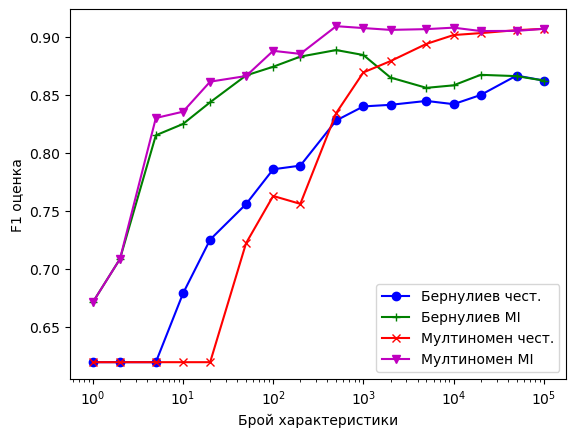

In [19]:
import matplotlib.pyplot as plt

plt.plot(x,yBF,'-bo')
plt.plot(x,yBM,'-g+')
plt.plot(x,yMF,'-rx')
plt.plot(x,yMM,'-mv')
plt.ylabel('F1 оценка')
plt.xlabel('Брой характеристики')
plt.xscale("log")
plt.legend(['Бернулиев чест.','Бернулиев MI','Мултиномен чест.','Мултиномен MI'])
plt.show()

### Линеен класификатор

In [20]:
cEco = classes.index('E-Economy')
cMil = classes.index('S-Military')
cCult = classes.index('C-Culture')
cPol = classes.index('J-Politics')
testClassCorpusE = [testClassCorpus[cEco], testClassCorpus[cMil] ]
trainClassCorpusE = [trainClassCorpus[cEco], trainClassCorpus[cMil] ]

condProbBE, priorBE, VBE = trainBernoulliNB(trainClassCorpusE)
condProbME, priorME, VME = trainMultinomialNB(trainClassCorpusE)
NcE = [ len(classList) for classList in trainClassCorpusE ]

[                                                  --------------------------------------------------]
[                                                  --------------------------------------------------]


In [21]:
gamma = lambda text : applyMultinomialNB(priorME, condProbME, text)
confusionMatrix, precision, recall, Fscore, P, R, F1 = testClassifier(testClassCorpusE, gamma)
print('Матрица на обърквания: ')
for row in confusionMatrix:
    for val in row:
        print('{:4}'.format(val), end = '')
    print()
print('Прецизност: '+str(precision))
print('Обхват: '+str(recall))
print('F-оценка: '+str(Fscore))
print('Обща презизност: '+str(P)+', обхват: '+str(R)+', F-оценка: '+str(F1))
print()

[                                                  -------------------------------------------------------]
Матрица на обърквания: 
  60   5
   4 154
Прецизност: [0.9375, 0.9685534591194969]
Обхват: [0.9230769230769231, 0.9746835443037974]
F-оценка: [0.9302325581395349, 0.9716088328075709]
Обща презизност: 0.959502002425473, обхват: 0.9596412556053812, F-оценка: 0.9595716239633164



In [22]:
featureSetE = selectFeaturesByMI(NcE,VBE,2)

In [23]:
gamma = lambda text : applyMultinomialNB(priorME, condProbME, text, featureSetE)
confusionMatrix, precision, recall, Fscore, P, R, F1 = testClassifier(testClassCorpusE, gamma)
print('Матрица на обърквания: ')
for row in confusionMatrix:
    for val in row:
        print('{:4}'.format(val), end = '')
    print()
print('Прецизност: '+str(precision))
print('Обхват: '+str(recall))
print('F-оценка: '+str(Fscore))
print('Обща презизност: '+str(P)+', обхват: '+str(R)+', F-оценка: '+str(F1))
print()


[                                                  -------------------------------------------------------]
Матрица на обърквания: 
  21  44
   0 158
Прецизност: [1.0, 0.7821782178217822]
Обхват: [0.3230769230769231, 1.0]
F-оценка: [0.48837209302325585, 0.8777777777777778]
Обща презизност: 0.8456688718199175, обхват: 0.8026905829596414, F-оценка: 0.8236194329382259



In [26]:
print('Features = '+str(featureSetE))

featureListE = list(featureSetE)
b = math.log(priorME[0] / priorME[1])
w = [ math.log(condProbME[feature][0] / condProbME[feature][1]) for feature in featureListE]
print('w='+str(w)+', b='+str(b))

Features = {'военни', 'банка'}
w=[-3.8661647982848426, 4.552242736403306], b=-0.8890053230714332


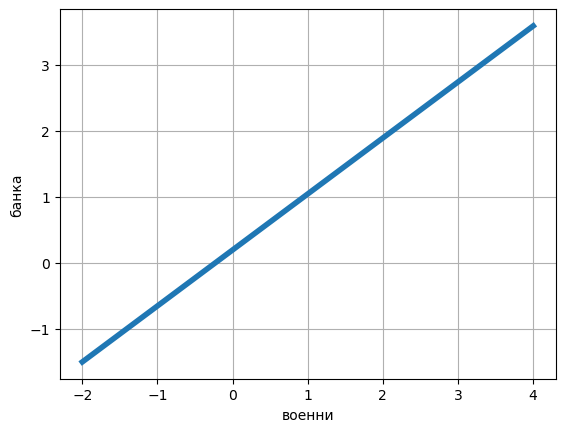

In [27]:
X = [*range(-2,5)]
Y = [ (-b - w[0] * x) / w[1] for x in X]
plt.plot(X,Y, linewidth=4)
plt.xlabel(featureListE[0])
plt.ylabel(featureListE[1])
plt.grid(True)
plt.show()
